# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd
df = pd.read_excel('geo.xlsx', index_col= "Unnamed: 0")
from IPython.display import display
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
df.dropna()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_S = scaler.fit_transform(df)
novote_df_S =  df.drop('comment_class', 1) 
novote_df_S = scaler.fit_transform(novote_df_S)
print(df)

                x          y  comment_class
0       37.612416  55.777454             -1
1       37.612416  55.777454             -1
2       37.603298  55.742108             -1
3       37.558526  55.728758             -1
4       37.566431  55.731794             -1
...           ...        ...            ...
108801  37.454528  55.792331             -1
108802  37.384325  55.899068             -1
108803  37.421066  55.848756              1
108804  37.448509  55.793065             -1
108805  37.451249  55.836620             -1

[108806 rows x 3 columns]


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (24, 18)

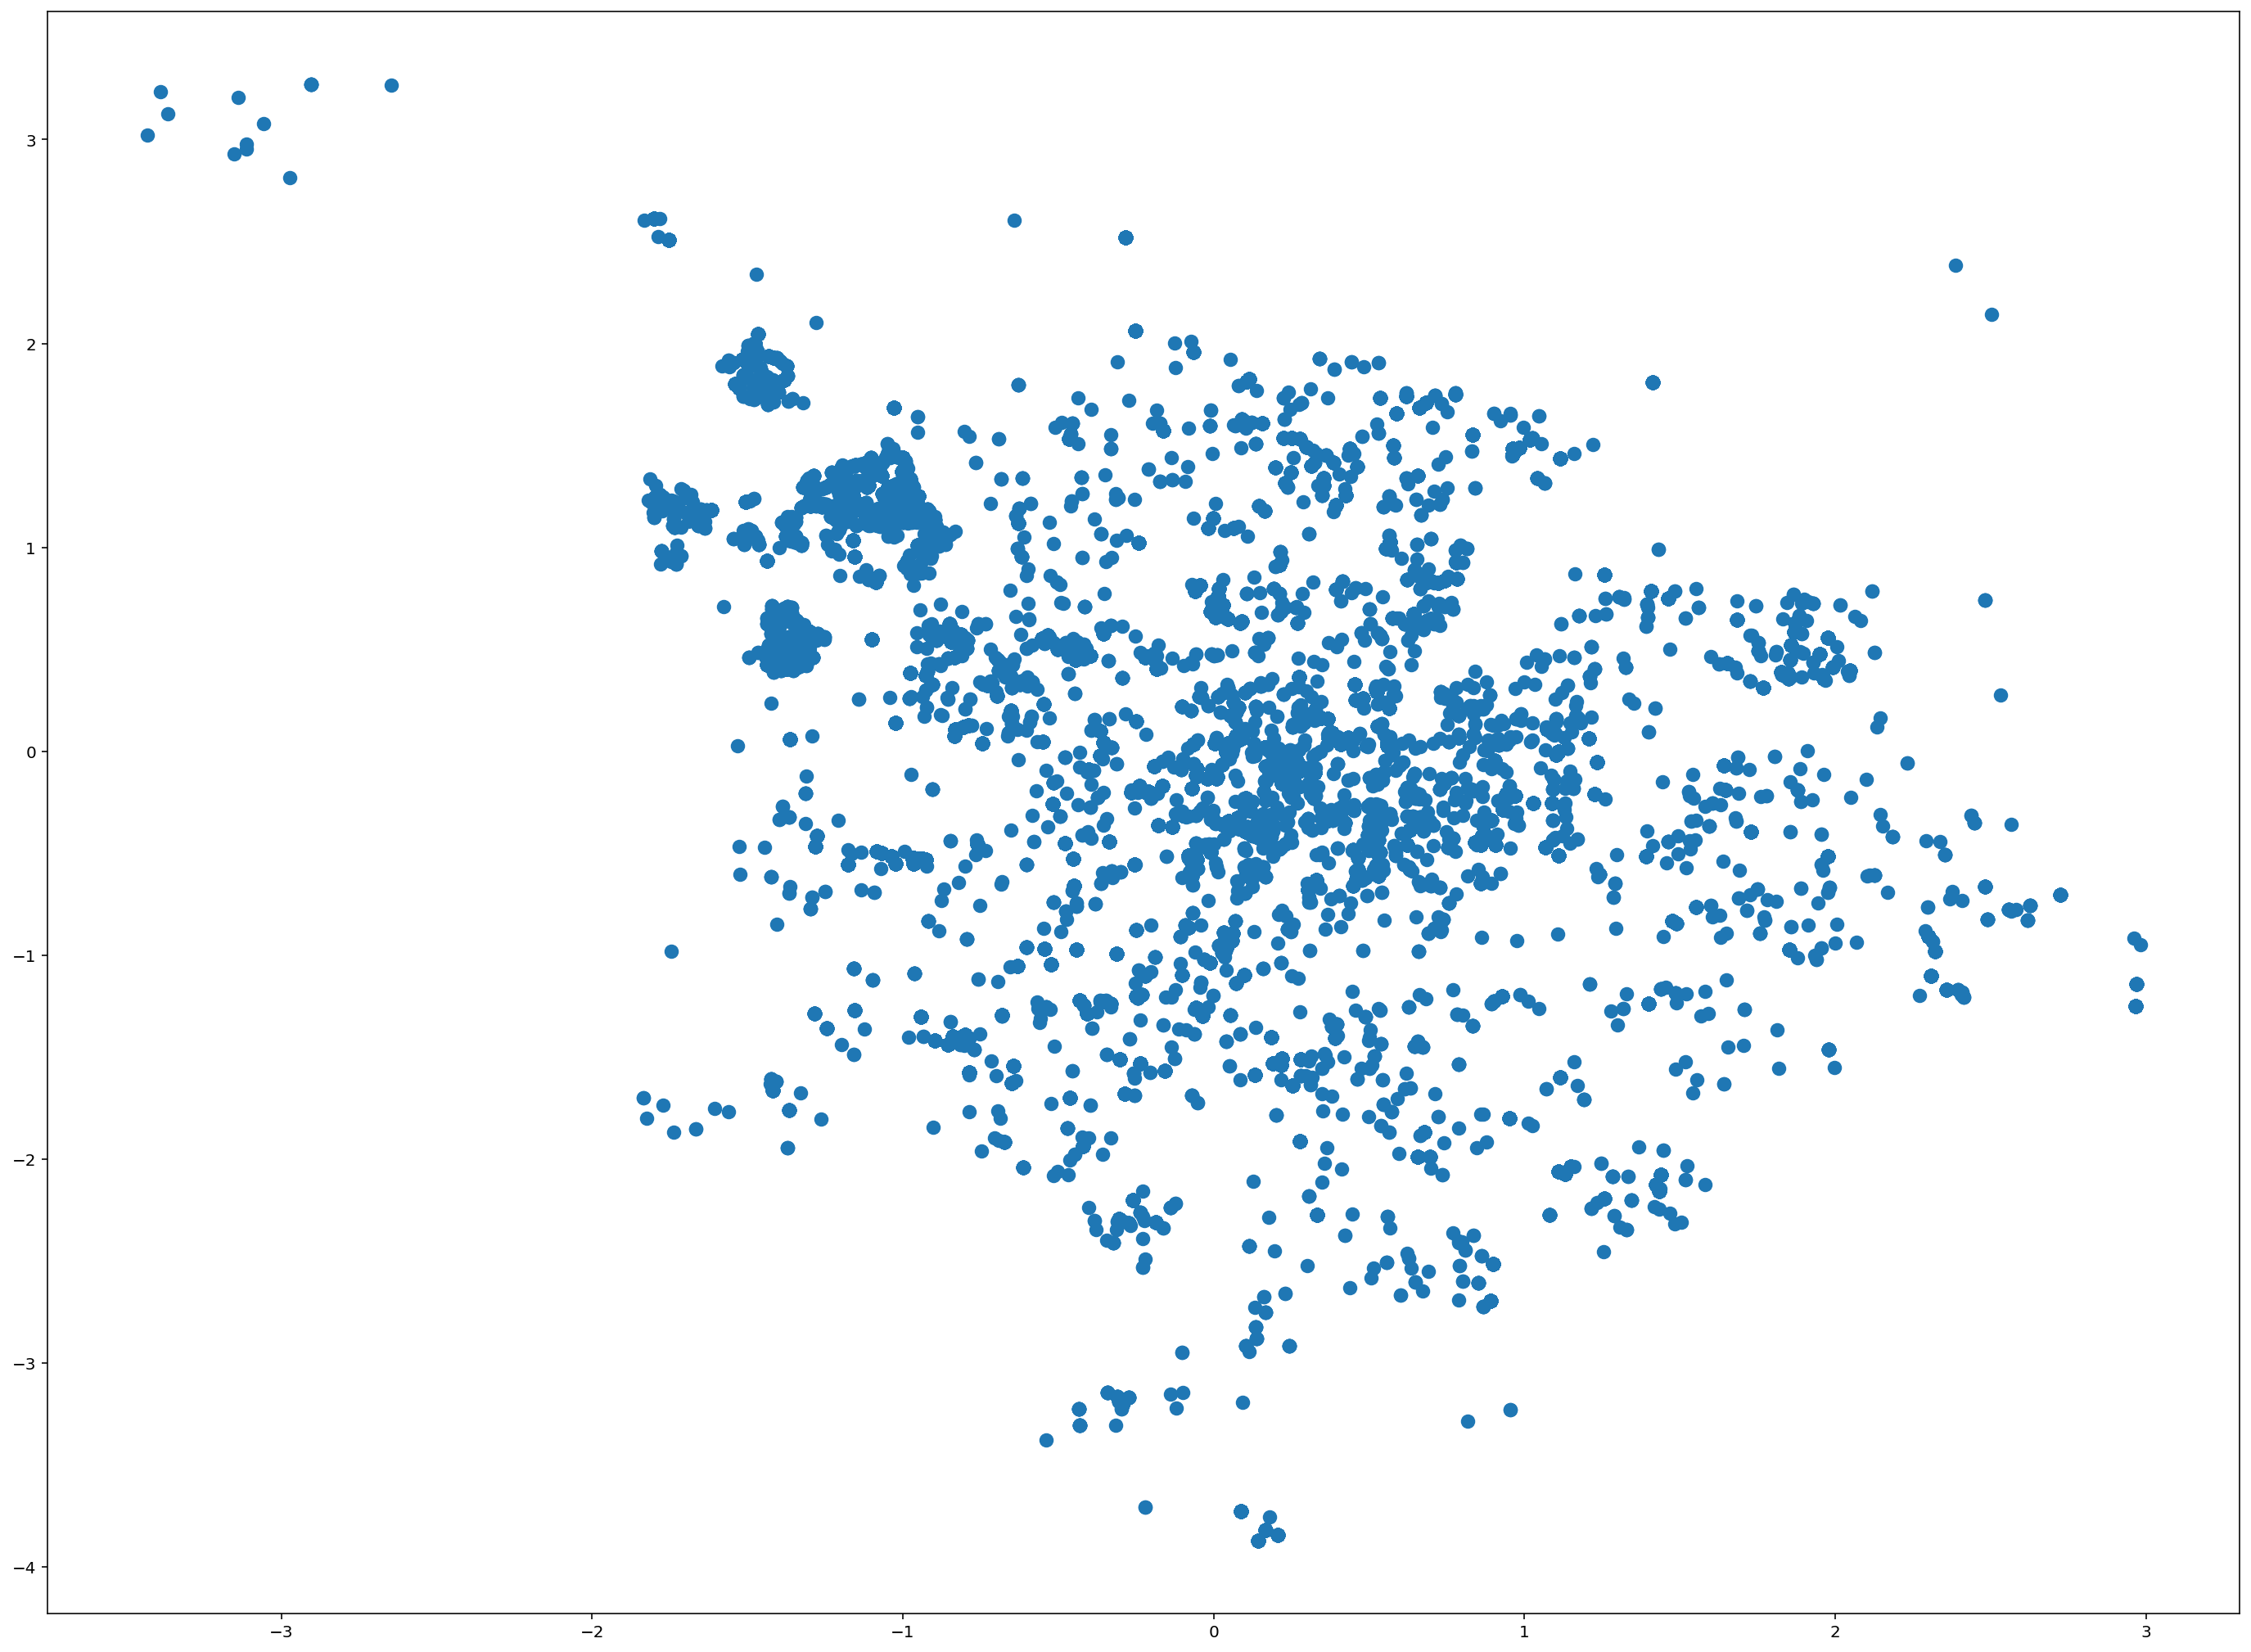

In [3]:
plt.scatter(df_S[:, 0], df_S[:, 1], cmap='autumn', s=60)

In [50]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.24, min_samples=3, n_jobs= 10).fit(novote_df_S)

In [51]:
from sklearn import metrics

In [52]:
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 13
Estimated number of noise points: 9


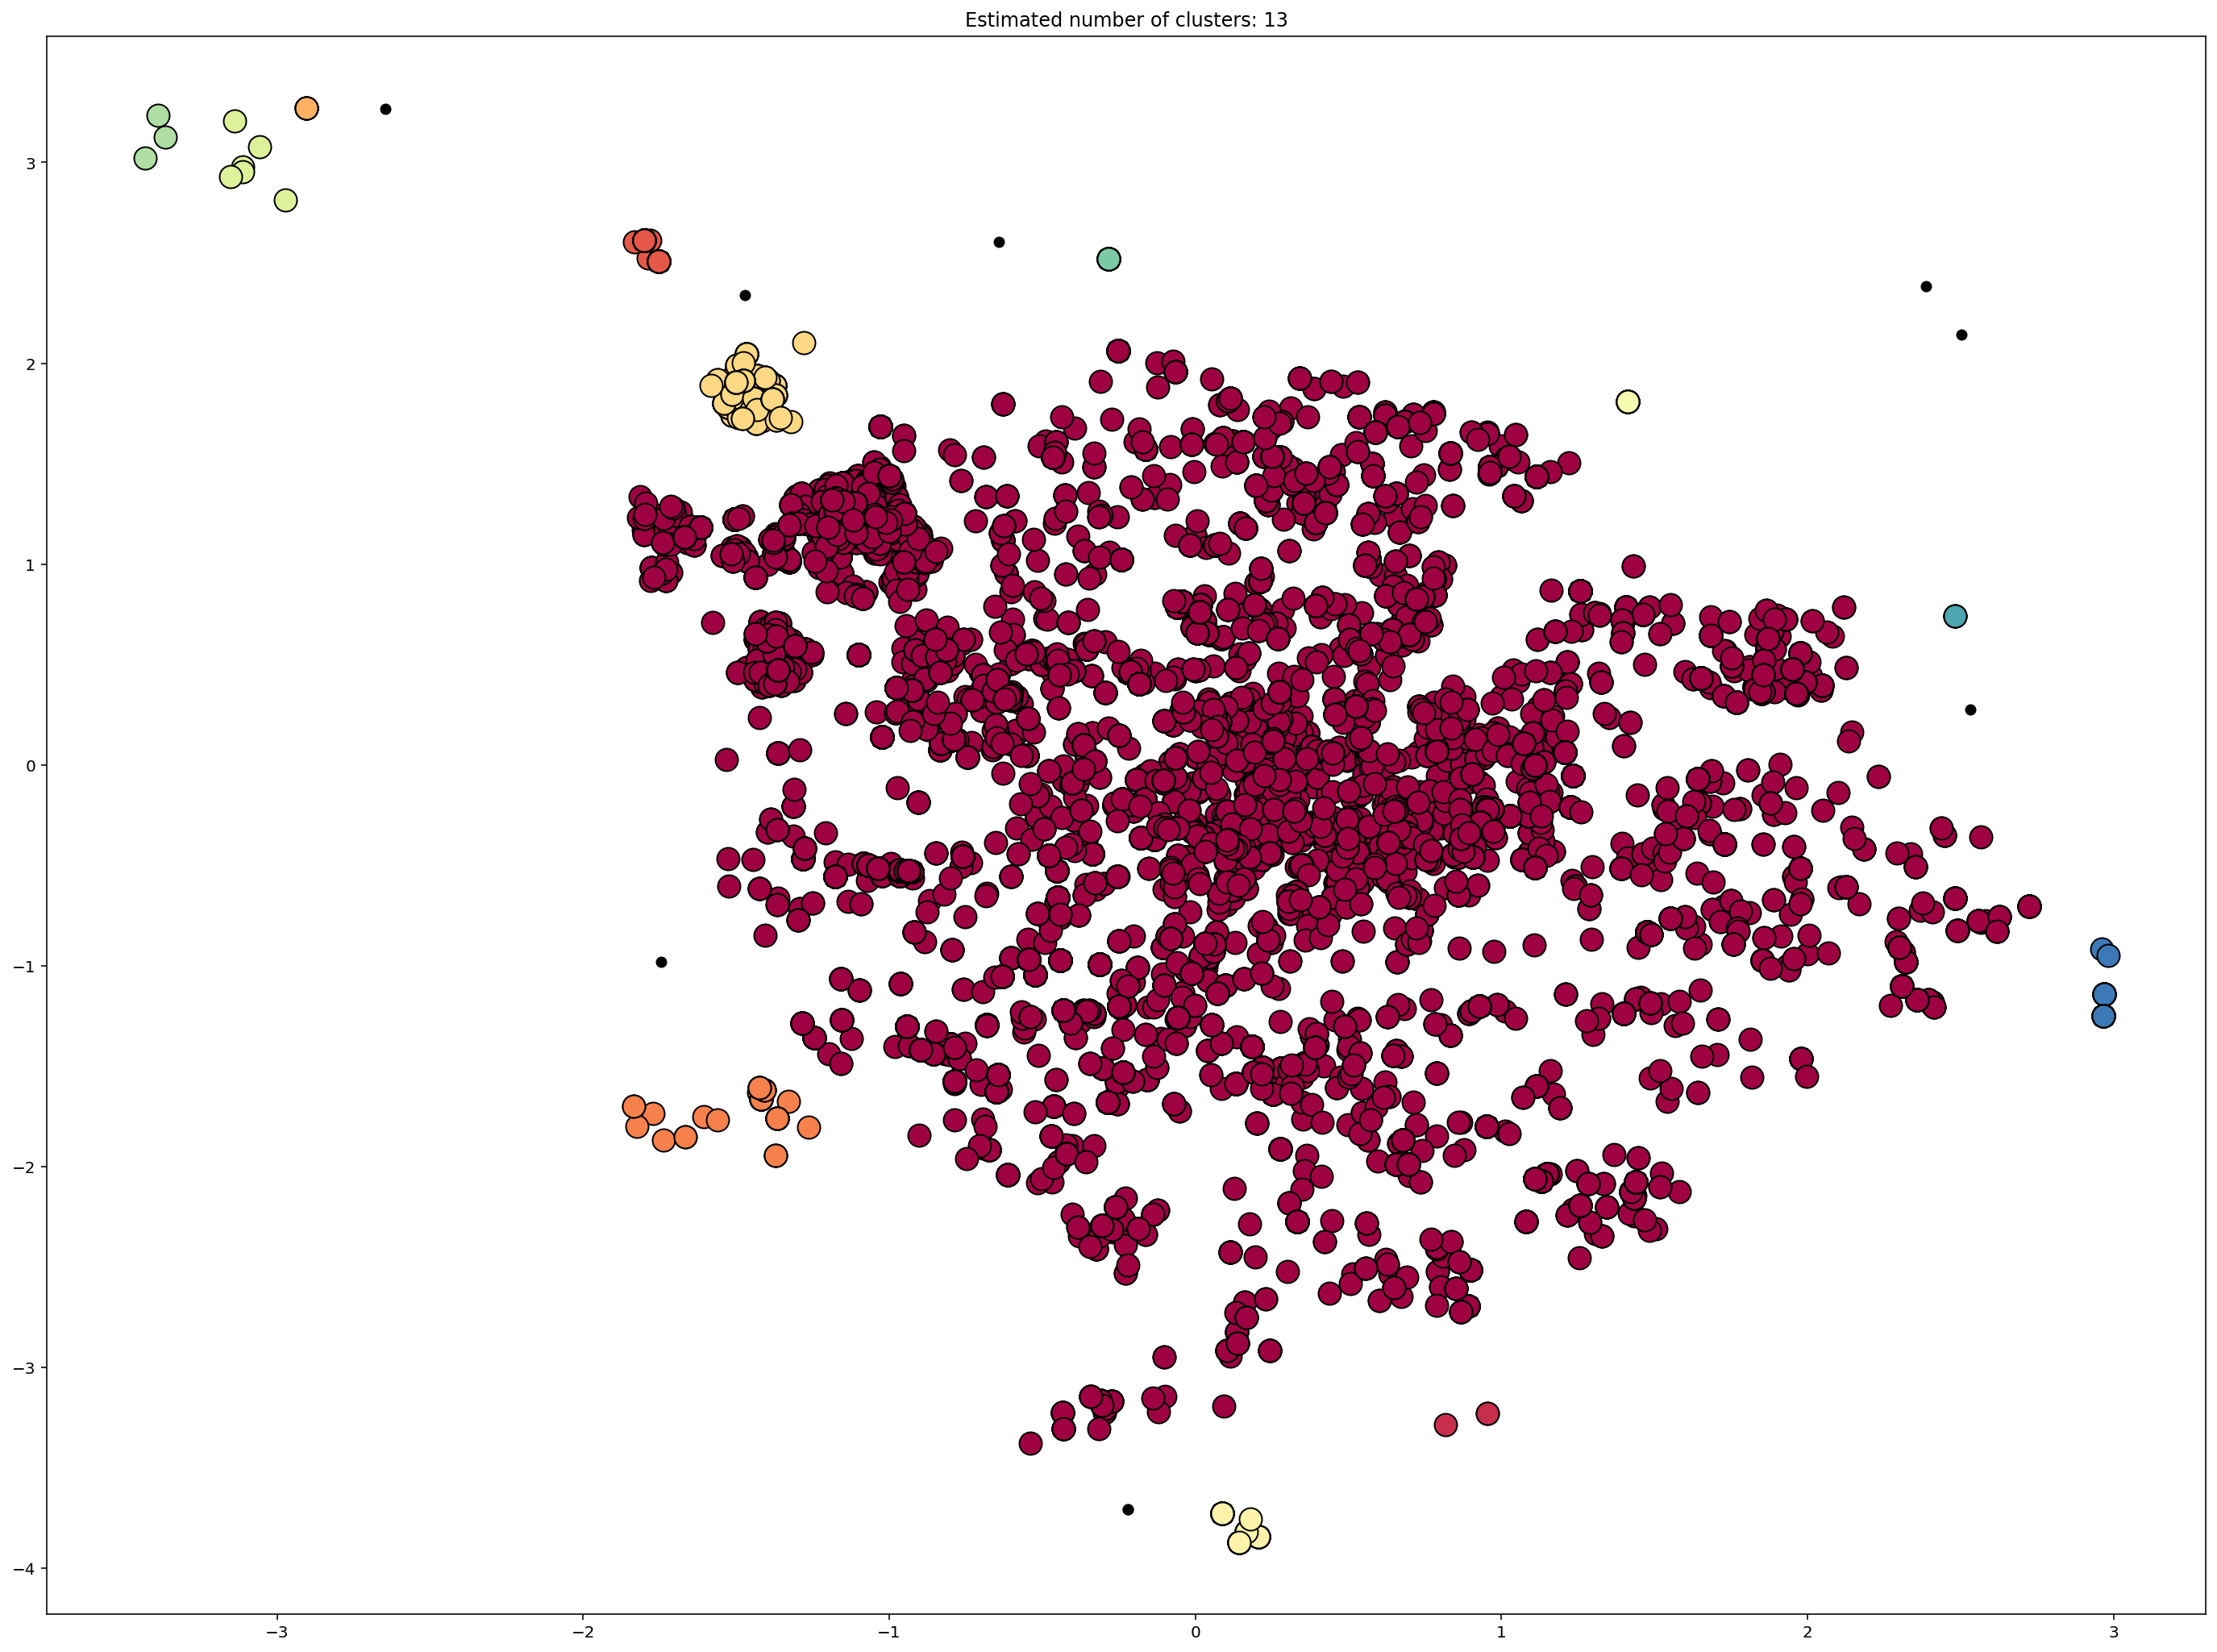

In [53]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = novote_df_S[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = novote_df_S[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [58]:

from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(preference=50).fit(df_S)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_S, labels, metric='sqeuclidean'))

import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = df_S[cluster_centers_indices[k]]
    plt.plot(df_S[class_members, 0], df_S[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in df_S[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

MemoryError: Unable to allocate 88.2 GiB for an array with shape (108806, 108806) and data type float64